In [26]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from src.models.backbones.wdcnn import WDCNN
from src.models.backbones.mininet import mininet
from src.utils.config import setup_config


In [27]:
device = torch.device("mps")

config = setup_config("arotor/grad-cam")

# Model
model = WDCNN(config)  # XXX WDCNN
# model = mininet(config)  # XXX Mininet
model = model.to(device)

# Model weights
model_weights = torch.load(
    # os.path.join("model_weights", "Base_ARotor_mininet_low_freq_2048", "0000", "model_0.9954.pth"),  # XXX Mininet
    # os.path.join("model_weights", "Base_ARotor_mininet_2", "0_10-29_23-55-55", "model_1.0000.pth"),  # XXX Mininet
    # os.path.join("model_weights", "Base_ARotor_mininet_low_freq", "0000", "model_1.0000.pth"),  # XXX Mininet
    os.path.join("model_weights", "Base_ARotor_wdcnn_tsa_110_em16_k3", "0000", "model_0.9979.pth"),
    # os.path.join("model_weights", "Base_ARotor_wdcnn_tsa_110_em8_k4", "0000", "model_0.9975.pth"),
    # os.path.join("model_weights", "Base_ARotor_wdcnn_tsa_110_em8", "0000", "model_0.9996.pth"),
    # os.path.join("model_weights", "Base_ARotor_wdcnn_tsa_110", "0000", "model_0.9496.pth"),
    # os.path.join("model_weights", "Base_ARotor_wdcnn_tsa", "0000", "model_0.9413.pth"),
    # os.path.join("model_weights", "Base_ARotor_low_freq_2048", "0000", "model_0.9104.pth"),
    # os.path.join("model_weights", "Base_ARotor_low_freq", "0000", "model_1.0000.pth"),
    # os.path.join("model_weights", "Base_ARotor_wide", "0_10-29_23-30-59", "model_0.9996.pth"),
    # os.path.join("model_weights", "Base_ARotor_narrow", "0_10-29_23-31-51", "model_0.9750.pth"),
    # os.path.join("model_weights", "Base_ARotor_10-28_18-08-14", "0_10-28_18-08-14", "model_0.9729.pth"),
    map_location=torch.device(device),
)
#
new_model_weights = {}
for k in model_weights.keys():
    new_model_weights[k.replace("_orig_mod.", "").replace("backbone.", "")] = model_weights[k]
model.load_state_dict(new_model_weights)
model.train()  # * GRAD-CAM requires training mode


WDCNN(
  (cn_layer1): ConvLayer(
    (conv): Conv1d(1, 16, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout1d(p=0.0, inplace=False)
  )
  (cn_layer2): ConvLayer(
    (conv): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout1d(p=0.0, inplace=False)
  )
  (cn_layer3): ConvLayer(
    (conv): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout1d(p=0.0, inplace=False

In [28]:
def gradcam_2(grad_cam_model, layer, input_tensor):
    grad_cam_model.eval()
    output_tensor, selected_tensor = grad_cam_model(input_tensor)
    print("outputshape {}: \n".format(output_tensor.shape), "\nand selected shape{}\n".format(selected_tensor.shape))

    output_tensor.backward(gradient=torch.ones_like(output_tensor))
    # Get the gradients of the selected layer's output tensor
    # gradients = layer.weight.grad.detach().clone()  # XXX Mininet
    gradients = layer.get_act_grads().detach().clone()  # XXX WDCNN
    print("!!")
    print("gradients: ", gradients.shape)

    # Compute the global average pooling of the gradients
    # pooled_gradients = torch.mean(gradients, dim=0)  # voi kokeilla myös dim = [0,1] # XXX Mininet
    pooled_gradients = torch.mean(gradients, dim=[1, 2])  # voi kokeilla myös dim = [0,1] # XXX WDCNN
    print("pooled gradients", pooled_gradients.shape)

    # Get the activations of the selected layer's output tensor
    activations = selected_tensor.detach().clone()
    print("activations ", activations.shape)

    # Compute the weighted sum of the activations using the gradients as weights
    # for i in range(1):  # XXX Mininet
    # activations = activations.unsqueeze(1)  # XXX WDCNN WRONG?
    for i in range(gradients.shape[0]):  # XXX WDCNN
        activations[:, i, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    print("heatmap", heatmap.shape)

    # Apply ReLU to the heatmap
    heatmap = F.relu(heatmap)

    # Normalize the heatmap
    # heatmap /= torch.max(heatmap) # FIXME
    # heatmap /= 7000  # FIXME Hattuvakio

    return heatmap


# def gradcam(grad_cam_model, layer, input_tensor):
#     grad_cam_model.eval()
#     output_tensor, selected_tensor = grad_cam_model(input_tensor)
#     print("outputshape {}: \n".format(output_tensor.shape), "\nand selected shape{}\n".format(selected_tensor.shape))

#     output_tensor.backward(gradient=torch.ones_like(output_tensor))
#     # Get the gradients of the selected layer's output tensor
#     # gradients = layer.weight.grad.detach().clone()  # XXX Mininet
#     gradients = layer.get_act_grads().detach().clone()  # XXX WDCNN
#     print("!!")
#     print("gradients: ", gradients.shape)

#     # Compute the global average pooling of the gradients
#     # pooled_gradients = torch.mean(gradients, dim=0)  # voi kokeilla myös dim = [0,1] # XXX Mininet
#     pooled_gradients = torch.mean(gradients, dim=[0, 2])  # voi kokeilla myös dim = [0,1] # XXX WDCNN
#     print("pooled gradients", pooled_gradients.shape)

#     # Get the activations of the selected layer's output tensor
#     activations = selected_tensor.detach().clone()
#     print("activations ", activations.shape)

#     # Compute the weighted sum of the activations using the gradients as weights
#     # for i in range(1):  # XXX Mininet
#     # activations = activations.unsqueeze(1)  # XXX WDCNN WRONG?
#     for i in range(gradients.shape[1]):  # XXX WDCNN
#         activations[:, i, :] *= pooled_gradients[i]

#     heatmap = torch.mean(activations, dim=1).squeeze()
#     print("heatmap", heatmap.shape)

#     # Apply ReLU to the heatmap
#     heatmap = F.relu(heatmap)

#     # Normalize the heatmap
#     # heatmap /= torch.max(heatmap) # FIXME
#     heatmap /= 110  # FIXME Hattuvakio

#     return heatmap


# class GradCamModel(nn.Module):
#     def __init__(self, pretrained_model):
#         super().__init__()
#         self.gradients = None
#         self.tensorhook = []
#         self.layerhook = []
#         self.selected_out = None

#         # PRETRAINED MODEL
#         self.pretrained = pretrained_model
#         # self.layerhook.append(self.pretrained.fc1.register_forward_hook(self.forward_hook())) # XXX Mininet
#         # self.layerhook.append(self.pretrained.cn_layer1.conv.register_forward_hook(self.forward_hook()))  # XXX WDCNN 1
#         self.layerhook.append(self.pretrained.cn_layer1.register_forward_hook(self.forward_hook()))  # XXX WDCNN 2

#         for p in self.pretrained.parameters():
#             p.requires_grad = True

#     def activations_hook(self, grad):
#         self.gradients = grad

#     def get_act_grads(self):
#         return self.gradients

#     def forward_hook(self):
#         def hook(module, inp, out):
#             self.selected_out = out
#             self.tensorhook.append(out.register_hook(self.activations_hook))

#         return hook

#     def forward(self, x):
#         out = self.pretrained(x)
#         return out, self.selected_out


class GradCamModel_2(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None

        # PRETRAINED MODEL
        self.pretrained = pretrained_model
        # self.layerhook.append(self.pretrained.fc1.register_forward_hook(self.forward_hook())) # XXX Mininet
        self.layerhook.append(
            self.pretrained.cn_layer2.conv.register_forward_hook(self.forward_hook())
        )  # XXX WDCNN 1 # LAYER SELECTION
        # self.layerhook.append(self.pretrained.cn_layer1.register_forward_hook(self.forward_hook()))  # XXX WDCNN 2

        for p in self.pretrained.parameters():
            p.requires_grad = True

    def activations_hook(self, grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))

        return hook

    def forward(self, x):
        out = self.pretrained(x)
        return out, self.selected_out


def plot_gradcam(new_heatmap, sample, start_bin, end_bin):
    cut_heatmap = new_heatmap[start_bin:]
    cut_sample = sample[start_bin:]
    if end_bin is not None:
        cut_heatmap = new_heatmap[:end_bin]
        cut_sample = sample[:end_bin]

    plt.rcParams.update({"font.size": 18})
    plt.rcParams["text.usetex"] = True
    fig, ax = plt.subplots(figsize=(25, 7))

    ax.imshow(
        np.expand_dims(cut_heatmap, axis=1).T,
        cmap="Reds",
        aspect="auto",
        interpolation="nearest",
        extent=[-0.5, len(cut_sample) - 0.5, 0, 155],
        # extent=[-0.5, len(cut_sample) - 0.5, 0, cut_sample.max() + 3],
        alpha=0.5,
        vmin=0,
        vmax=1.0,
    )
    print("cut sample", len(cut_sample))
    ax.bar(
        range(len(cut_sample)),
        cut_sample,
    )
    # ax.plot(
    #     cut_sample,
    #     "k",
    # )
    ax.set_xlim(left=-1, right=len(cut_sample) + 0.5)
    ax.set_ylim(top=155, bottom=0)

    # FREQS
    # freqs = np.fft.rfftfreq(config["window_width"] // config["TSA_cycles"], 1 / 3012).round(2)[1 + start_bin :]
    # ticks = list(range(0, len(cut_sample), len(cut_sample) // 22))
    # ax.set_xticks(ticks=ticks, labels=[freqs[x] for x in ticks])
    # Harmonics
    ax.set_xticks(
        ticks=[0] + list(range(4, len(cut_sample) + 1, 5)),
        labels=[1] + list(range(5, len(cut_sample) + 2, 5)),
    )
    ax.set_yticks([])

    plt.xlabel("Harmonic \#")
    # plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    fig.tight_layout()

    # plt.savefig(dir + "{}_{}_{}_{}.pdf".format(sensor, rot_freq, num_shim, shim_thckns), format="pdf")


def plot_multiple_gradcam(all_heatmaps, all_sample_means, start_bin, end_bin):
    classes = {
        0: "Healthy gear",
        7: "0.05 mm x 1 shim",
        8: "0.05 mm x 2 shim",
        9: "0.05 mm x 3 shim",
    }

    plt.rcParams.update({"font.size": 20})
    plt.rcParams["text.usetex"] = True
    fig, axs = plt.subplots(4, 1, figsize=(12, 12))
    axs = axs.flatten()

    # sample_len = 1
    # sample_len = len(list(all_heatmaps.values())[0])
    max_val = max([all_sample_means[setup].max() for setup in all_heatmaps.keys()])  # / sample_len
    max_heatmap_val = max([all_heatmaps[setup].max() for setup in all_heatmaps.keys()])

    for i, setup in enumerate(all_heatmaps.keys()):
        cut_heatmap = all_heatmaps[setup][start_bin:]
        cut_sample = all_sample_means[setup][start_bin:]

        if end_bin is not None:
            cut_heatmap = cut_heatmap[:end_bin]
            cut_sample = cut_sample[:end_bin]

        # cut_sample /= sample_len

        axs[i].imshow(
            np.expand_dims(cut_heatmap, axis=1).T,
            cmap="Reds",
            aspect="auto",
            interpolation="nearest",
            extent=[-0.5, len(cut_sample) - 0.5, 0, max_val + max_val * 0.1],
            alpha=0.5,
            vmin=0,
            vmax=max_heatmap_val,
            # vmax=1.0,
        )

        # print("cut sample", len(cut_sample))
        axs[i].bar(
            range(len(cut_sample)),
            cut_sample,
            # np.log1p(cut_sample),
        )

        # axs[i].set_yscale("log")
        axs[i].set_title(classes[setup[1]])
        axs[i].set_xlim(left=-1, right=len(cut_sample) + 0.5)
        axs[i].set_xticks(
            ticks=[0] + list(range(4, len(cut_sample) + 1, 5)),
            labels=[1] + list(range(5, len(cut_sample) + 2, 5)),
        )
        # axs[i].set_yticks([])

    plt.xlabel("Harmonic component \#")
    fig.supylabel("Amplitude (Nm)")
    fig.tight_layout()

    plt.savefig(
        os.path.join(
            os.path.abspath(""),
            "reports",
            "processed",
            "grad_cam_figures",
            "t1_{}_{}_cn_layer2_batch3.pdf".format(
                ",".join(map(str, config["test_rpm"])), ",".join(map(str, config["grad_cam_class"]))
            ),
        ),
        format="pdf",
        bbox_inches="tight",
    )


def resize_hmap(heatmap):
    # correct_size = 272  # XXX
    correct_size = config["sample_cut"]
    if config["sample_cut"] == -1:
        correct_size = len(torch.fft.rfft(torch.ones(config["window_width"] // config["TSA_cycles"])))
    print("FFTFREQ LENGTH", correct_size)
    upsampled_hmap = F.interpolate(heatmap.unsqueeze(1), size=correct_size, mode="linear", align_corners=False).squeeze(
        1
    )
    print(upsampled_hmap.shape)
    return upsampled_hmap


In [29]:
# Get data

abs_path = os.path.abspath("")
data_folder = os.path.join(abs_path, "data")


def fewshot_data_selection(data, sensors, rpm, classes):
    selected_data = data.loc[:, sensors + ["rpm", "class"]]
    selected_data = selected_data[(selected_data["rpm"].isin(rpm)) & (selected_data["class"].isin(classes))]

    return selected_data


def get_AD_arotor_data(config, data_folder, device):
    # Load all data
    data = pd.read_feather(os.path.join(data_folder, "processed", "arotor.feather"))

    query_data = fewshot_data_selection(data, config["test_sensors"], config["test_rpm"], config["grad_cam_class"])

    query_data = query_data.groupby(by=["rpm", "class"], observed=True)[config["test_sensors"][0]].apply(list).to_dict()
    # Convert to tensors
    for k, v in query_data.items():
        new_tensor = torch.tensor(v, device=device)
        # Use second half of baseline measurements
        if k[1] == 0:
            new_tensor = new_tensor[len(v) // 2 :]
        query_data[k] = new_tensor

    return query_data


query_data = get_AD_arotor_data(config, data_folder, device)
print(query_data.keys())
setup = list(query_data.keys())[0]
print(query_data[setup].shape)


dict_keys([(500, 0), (500, 7), (500, 8), (500, 9)])
torch.Size([225749])


(110,)
torch.Size([3, 1, 110])


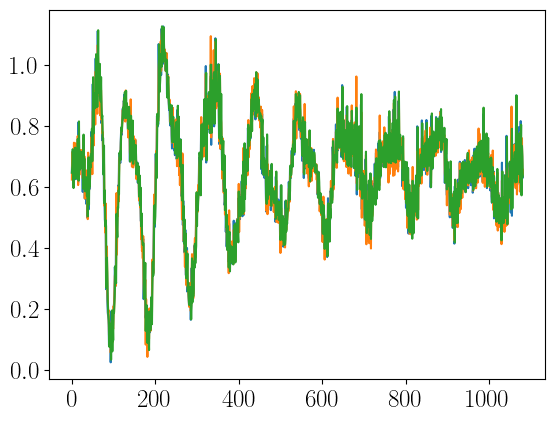

In [30]:
# Window data

offset = 6000
rot_len = 1082
# window_width = config["window_width"]
# rotations_per_window = window_width // rot_len + 1

all_samples = {}
all_sample_means = {}

for i, setup in enumerate(query_data.keys()):
    time_samples = (
        query_data[setup]
        .cpu()
        .numpy()[
            np.array(
                [
                    np.r_[offset + i * config["window_width"] : offset + (i + 1) * config["window_width"]]
                    for i in range(3)
                    # for i in range(24)
                ]
            )
        ]
    )

    time_samples = time_samples.reshape(time_samples.shape[0], config["TSA_cycles"], rot_len)
    time_samples = time_samples.mean(axis=1)

    if i == 1:
        plt.plot(time_samples[:].T)

    # FFT data
    samples = np.fft.rfft(time_samples)[:, 1:][:, : config["sample_cut"]]
    samples_mean = np.abs(
        np.fft.rfft(time_samples, norm="forward")[:, 1:][:, : config["sample_cut"]].mean(axis=0)
    )  # Correctly averaged FFT
    # plt.show()
    # plt.plot(samples_mean)
    samples = np.abs(samples)

    samples = torch.tensor(samples, device=device, dtype=torch.float32)
    samples = samples.unsqueeze(1)

    if i == 0:
        print(samples_mean.shape)
        print(samples.shape)

    all_samples[setup] = samples
    all_sample_means[setup] = samples_mean


outputshape torch.Size([3, 16]): 
 
and selected shapetorch.Size([3, 32, 54])

!!
gradients:  torch.Size([32, 16, 3])
pooled gradients torch.Size([32])
activations  torch.Size([3, 32, 54])
heatmap torch.Size([3, 54])
FFTFREQ LENGTH 110
torch.Size([3, 110])
Heatmap shape torch.Size([3, 54])
new_heatmap!! torch.Size([3, 110])
outputshape torch.Size([3, 16]): 
 
and selected shapetorch.Size([3, 32, 54])

!!
gradients:  torch.Size([32, 16, 3])
pooled gradients torch.Size([32])
activations  torch.Size([3, 32, 54])
heatmap torch.Size([3, 54])
FFTFREQ LENGTH 110
torch.Size([3, 110])
outputshape torch.Size([3, 16]): 
 
and selected shapetorch.Size([3, 32, 54])

!!
gradients:  torch.Size([32, 16, 3])
pooled gradients torch.Size([32])
activations  torch.Size([3, 32, 54])
heatmap torch.Size([3, 54])
FFTFREQ LENGTH 110
torch.Size([3, 110])
outputshape torch.Size([3, 16]): 
 
and selected shapetorch.Size([3, 32, 54])

!!
gradients:  torch.Size([32, 16, 3])
pooled gradients torch.Size([32])
activati

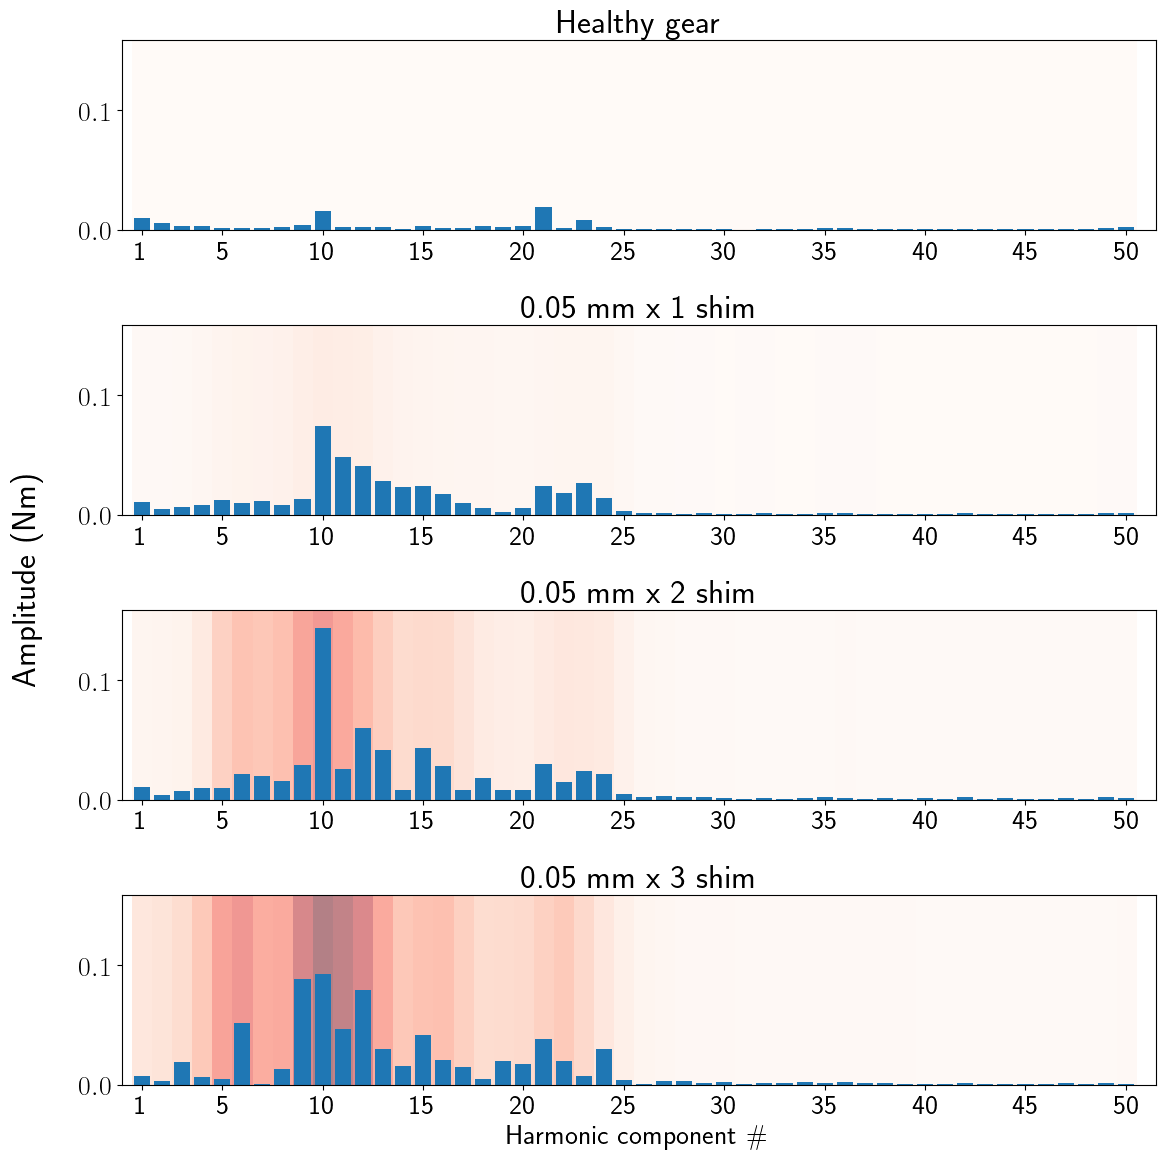

In [31]:
# Create heatmaps

gradcam_model = GradCamModel_2(model)

all_heatmaps = {}

for i, setup in enumerate(query_data.keys()):
    # heatmap = gradcam(gradcam_model, model.fc1, all_samples[setup])  # XXX Mininet
    heatmap = gradcam_2(gradcam_model, model.cn_layer2, all_samples[setup])  # XXX WDCNN # LAYER SELECTION
    heatmap = heatmap.detach().cpu()
    new_heatmap = resize_hmap(heatmap)
    all_heatmaps[setup] = new_heatmap.mean(0)
    if i == 0:
        print("Heatmap shape", heatmap.shape)
        print("new_heatmap!!", new_heatmap.shape)

# plot_gradcam(
#     new_heatmap.mean(dim=0),
#     samples_mean,
#     0,
#     None,
# )

plot_multiple_gradcam(all_heatmaps, all_sample_means, 0, 50)


In [32]:
# # Create heatmaps

# gradcam_model = GradCamModel(model)

# # heatmap = gradcam(gradcam_model, model.fc1, samples)  # XXX Mininet
# heatmap = gradcam(gradcam_model, model.cn_layer1, samples)  # XXX WDCNN
# heatmap = heatmap.detach().cpu()
# print("Heatmap shape", heatmap.shape)
# new_heatmap = resize_hmap(heatmap)
# print("new_heatmap!!", new_heatmap.shape)

# plot_gradcam(
#     new_heatmap.mean(dim=0),
#     samples_mean,
#     0,
#     None,
# )


cut sample 110


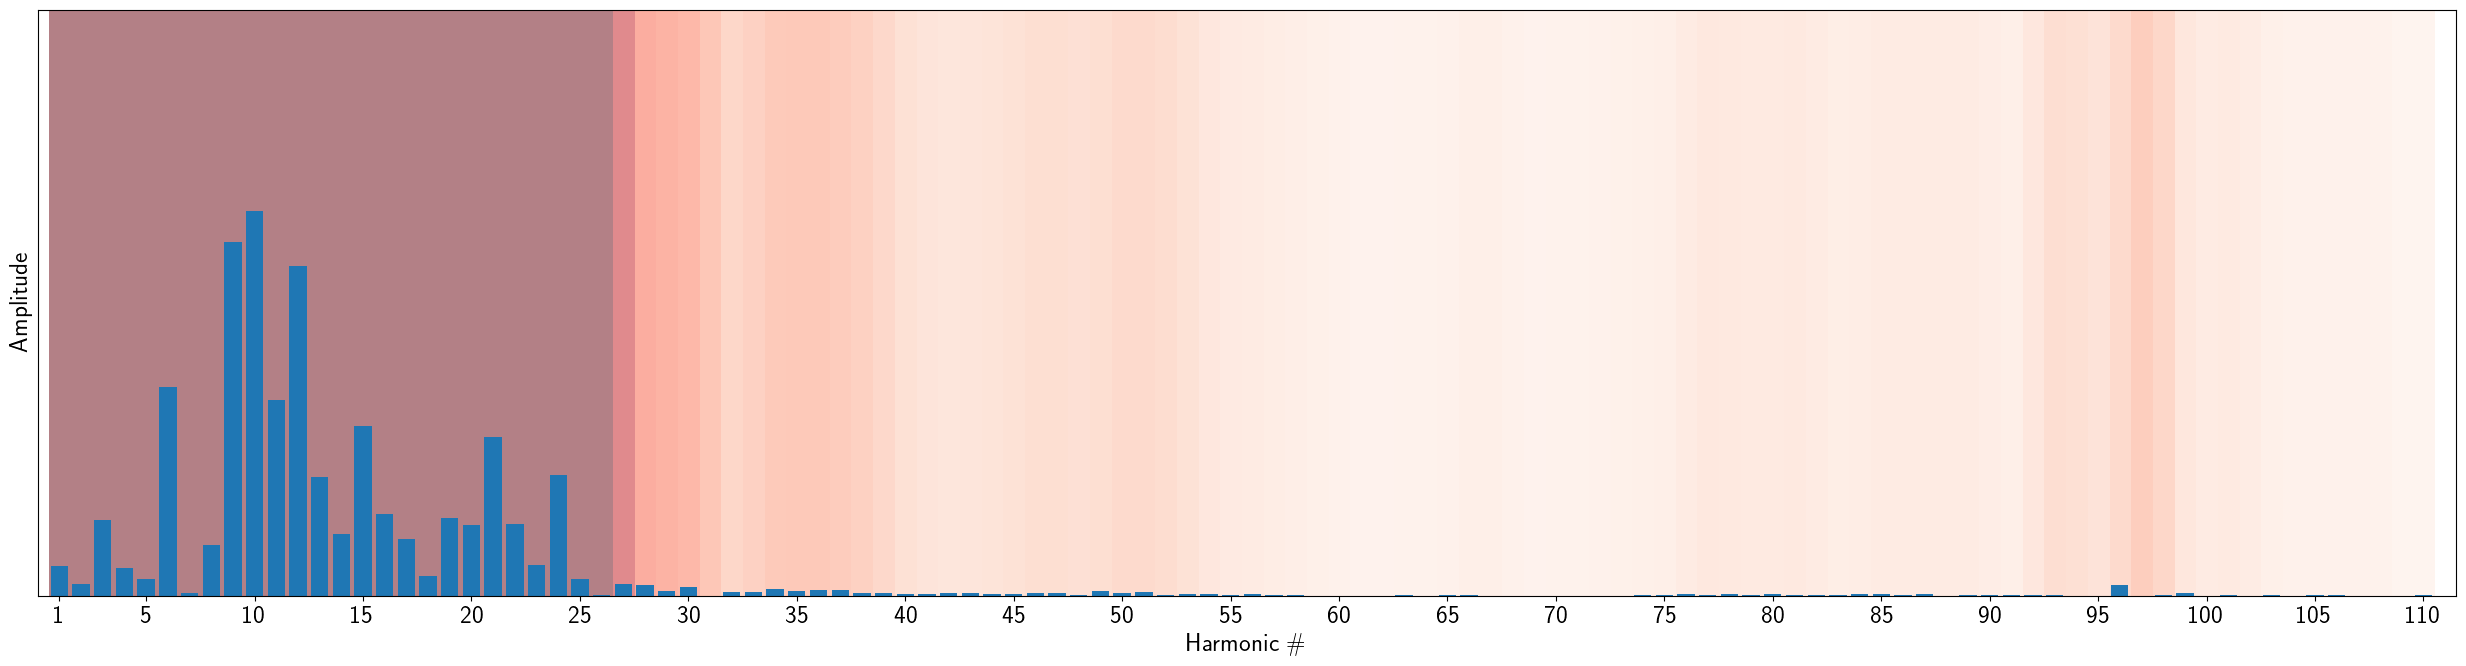

In [33]:
plot_gradcam(
    new_heatmap[0],
    samples[0, 0, :].cpu().numpy(),
    0,
    None,
)


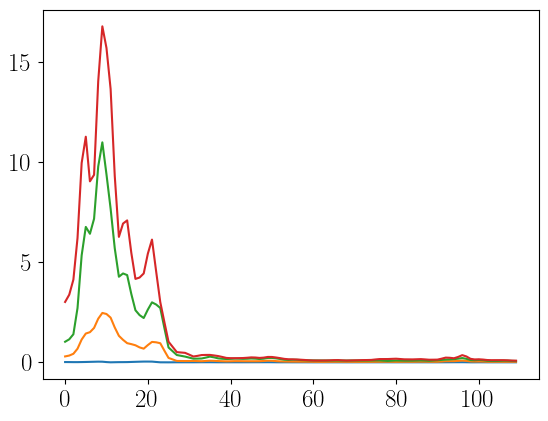

In [34]:
plt.plot(all_heatmaps[(500, 0)][:])
plt.plot(all_heatmaps[(500, 7)][:])
plt.plot(all_heatmaps[(500, 8)][:])
plt.plot(all_heatmaps[(500, 9)][:])


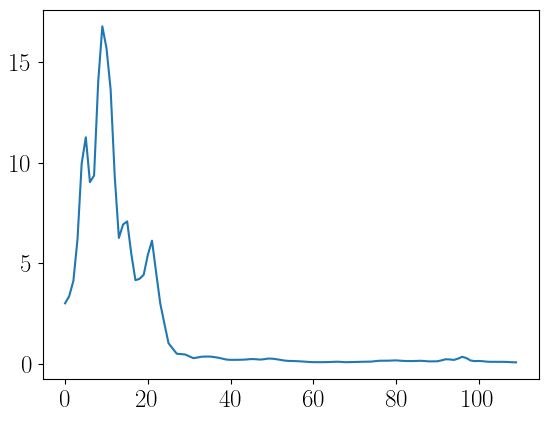

In [35]:
plt.plot(new_heatmap.mean(dim=0))


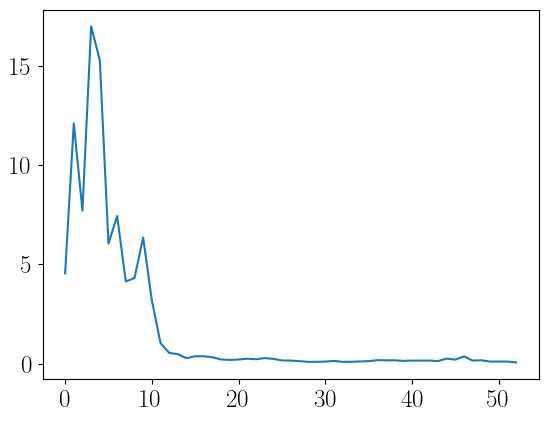

In [36]:
plt.plot(heatmap[0, 1:])


In [37]:
plt.plot(heatmap[20, 1:])


IndexError: index 20 is out of bounds for dimension 0 with size 3

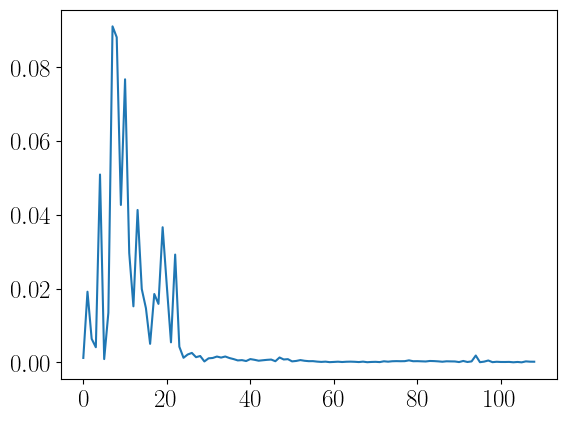

In [ ]:
plt.plot(samples_mean[1:])


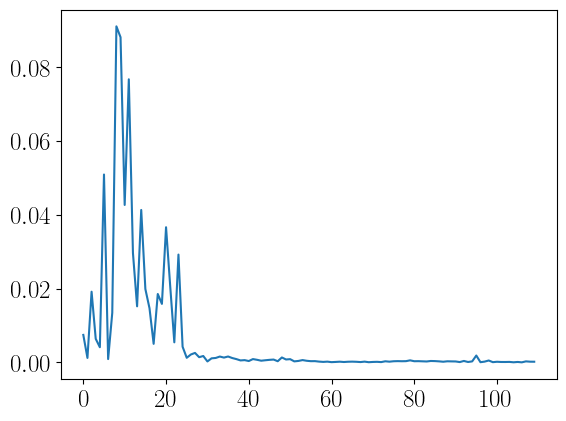

In [ ]:
plt.plot(samples_mean)


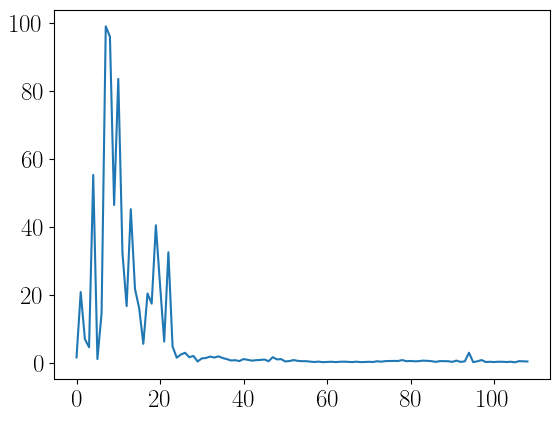

In [ ]:
plt.plot(samples.mean(dim=0).squeeze()[1:].cpu().numpy())
